In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
import squarify

In [29]:
df= pd.read_csv('merged_data.csv')
df.head()

,Member_number,Date,productId,items,order_id,productName,price,Category,Total_Cost,Month
0,1808,2015-07-21,1,3,2988,tropical fruit,7.8,Fresh Food,23.4,2015-07
1,2552,2015-01-05,2,1,5784,whole milk,1.8,Dairy,1.8,2015-01
2,2300,2015-09-19,3,3,4852,pip fruit,3.0,Fresh Food,9.0,2015-09
3,1187,2015-12-12,4,3,688,other vegetables,0.8,Fresh Food,2.4,2015-12
4,3037,2015-02-01,2,1,7585,whole milk,1.8,Dairy,1.8,2015-02


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38765 entries, 0 to 38764
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Member_number  38765 non-null  int64  
 1   Date           38765 non-null  object 
 2   productId      38765 non-null  int64  
 3   items          38765 non-null  int64  
 4   order_id       38765 non-null  int64  
 5   productName    38765 non-null  object 
 6   price          38765 non-null  float64
 7   Category       38765 non-null  object 
 8   Total_Cost     38765 non-null  float64
 9   Month          38765 non-null  object 
dtypes: float64(2), int64(4), object(4)
memory usage: 3.0+ MB


In [31]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

### Create RFM analysis for each customers

In [32]:
current_date = df['Date'].max()
print(f"Ngày hiện tại (max date): {current_date}")

Ngày hiện tại (max date): 2015-12-30 00:00:00


In [33]:
rfm_df = df.groupby('Member_number').agg({
    'Date': lambda x: (current_date - x.max()).days,  # Recency: Số ngày từ giao dịch cuối cùng
    'order_id': 'nunique',                            # Frequency: Số đơn hàng duy nhất
    'Total_Cost': 'sum'                               # Monetary: Tổng chi tiêu
}).reset_index()
rfm_df.columns = ['Member_number', 'Recency', 'Frequency', 'Monetary']

In [34]:
rfm_df = rfm_df.sort_values('Monetary', ascending=False)
rfm_df.head()

,Member_number,Recency,Frequency,Monetary
1388,2433,3,7,375.31
1159,2193,91,11,361.45
772,1793,26,10,345.10
2225,3289,4,10,334.15
1692,2743,142,7,312.46


In [35]:
rfm_df.describe()

,Member_number,Recency,Frequency,Monetary
count,3898.000000,3898.000000,3898.000000,3898.000000
mean,3002.959979,187.701385,3.838635,85.212835
std,1155.806001,159.912688,1.883678,55.620089
min,1000.000000,0.000000,1.000000,1.300000
25%,1999.250000,57.000000,2.000000,43.810000
50%,3004.500000,141.000000,4.000000,74.900000
75%,4002.750000,280.000000,5.000000,115.295000
max,5000.000000,727.000000,11.000000,375.310000


3898 Khách hàng giao dịch. Khách hàng chi ít nhất là 1.3 chi nhiều nhất là 375.31

Trung bình 1 khách hàng chi khoảng 85 trong 2 năm. 75% số lượng khách hàng chi dưới 115.29

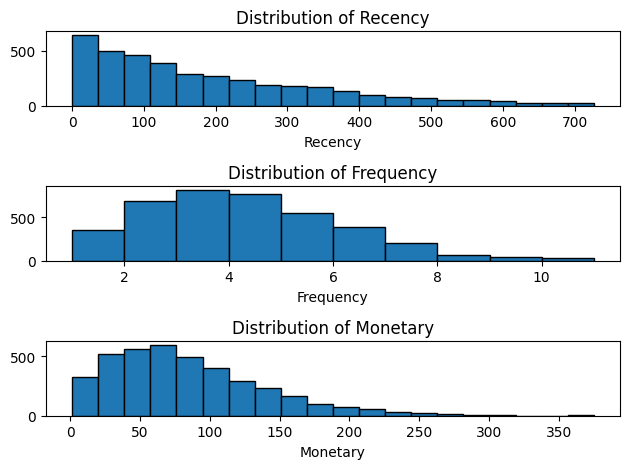

In [36]:
# Vẽ phân phối của 'Recency'
plt.subplot(3, 1, 1) # 3 hàng, 1 cột, vị trí thứ nhất
plt.hist(rfm_df['Recency'], bins=20, edgecolor='black') # Chọn số lượng bins phù hợp
plt.title('Distribution of Recency')
plt.xlabel('Recency')

# Vẽ phân phối của 'Frequency'
plt.subplot(3, 1, 2) # 3 hàng, 1 cột, vị trí thứ hai
plt.hist(rfm_df['Frequency'], bins=10, edgecolor='black') # Chọn số lượng bins phù hợp
plt.title('Distribution of Frequency')
plt.xlabel('Frequency')

# Vẽ phân phối của 'Monetary'
plt.subplot(3, 1, 3) # 3 hàng, 1 cột, vị trí thứ ba
plt.hist(rfm_df['Monetary'], bins=20, edgecolor='black') # Chọn số lượng bins phù hợp
plt.title('Distribution of Monetary')
plt.xlabel('Monetary')

plt.tight_layout()
plt.show()

1. Recency
Phân bố lệch phải (right-skewed): Phần lớn khách hàng có giá trị Recency thấp (gần 0), nghĩa là họ đã mua hàng gần đây.
Nhiều khách hàng vẫn đang hoạt động gần đây (Recency thấp), cho thấy cửa hàng có lượng khách hàng thường xuyên hoặc mới.

2. Frequency
Phân bố lệch phải (right-skewed): Phần lớn khách hàng có giá trị Frequency thấp, cao nhất ở khoảng 2-4 lần, rất ít khách hàng có Frequency cao (>8).

3. Monetary
Phân bố lệch phải: Hầu hết khách hàng có giá trị Monetary thấp (<100), với đỉnh cao nhất ở khoảng 0-50.
Đa số khách hàng chi tiêu ít, có thể do họ chỉ mua các sản phẩm giá rẻ hoặc không mua nhiều sản phẩm trong mỗi giao dịch.
Cơ hội: Nhóm khách hàng có Monetary cao (>200) là nhóm có giá trị cao.

In [37]:
# Create labels for Recency, Frequency, Monetary
r_labels = range(4, 0, -1) # số ngày tính từ lần cuối mua hàng lớn thì gán nhãn nhỏ, ngược lại thì nhãn lớn
f_labels = range(1, 5)
m_labels = range(1, 5)

In [38]:
[*r_labels]

[4, 3, 2, 1]

In [39]:
# Assign these labels to 4 equal percentile groups
r_groups = pd.qcut(rfm_df['Recency'].rank(method='first'), q=4, labels=r_labels)

f_groups = pd.qcut(rfm_df['Frequency'].rank(method='first'), q=4, labels=f_labels)

m_groups = pd.qcut(rfm_df['Monetary'].rank(method='first'), q=4, labels=m_labels)

In [40]:
# Create new columns R, F, M
rfm_df = rfm_df.assign(R = r_groups.values, F = f_groups.values,  M = m_groups.values)
rfm_df.head()

,Member_number,Recency,Frequency,Monetary,R,F,M
1388,2433,3,7,375.31,4,4,4
1159,2193,91,11,361.45,3,4,4
772,1793,26,10,345.10,4,4,4
2225,3289,4,10,334.15,4,4,4
1692,2743,142,7,312.46,2,4,4


In [41]:
def join_rfm(x): return str(int(x['R'])) + str(int(x['F'])) + str(int(x['M']))
rfm_df['RFM_Segment'] = rfm_df.apply(join_rfm, axis=1)

In [42]:
rfm_df.head()

,Member_number,Recency,Frequency,Monetary,R,F,M,RFM_Segment
1388,2433,3,7,375.31,4,4,4,444
1159,2193,91,11,361.45,3,4,4,344
772,1793,26,10,345.10,4,4,4,444
2225,3289,4,10,334.15,4,4,4,444
1692,2743,142,7,312.46,2,4,4,244


In [43]:
rfm_count_unique = rfm_df.groupby('RFM_Segment')['RFM_Segment'].nunique()

In [44]:
print(rfm_count_unique.sum())

63


- Having 63 different segments using the concatenate method quickly becomes unwieldy for any practical use. We will need a more concise way to define our segments.

#### Calculate RFM score and level

In [45]:
# Calculate RFM_Score
rfm_df['RFM_Score'] = rfm_df[['R','F','M']].sum(axis=1)
rfm_df.head()

,Member_number,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score
1388,2433,3,7,375.31,4,4,4,444,12
1159,2193,91,11,361.45,3,4,4,344,11
772,1793,26,10,345.10,4,4,4,444,12
2225,3289,4,10,334.15,4,4,4,444,12
1692,2743,142,7,312.46,2,4,4,244,10


### Manual Segmentation

In [46]:
def rfm_level(df):
    if df['RFM_Score'] == 12:
        return 'Best Customers'  # High recency, frequency, and monetary
    elif df['R'] == 1 and df['F'] == 1 and df['M'] == 1:
        return 'New Customers'  # Very low recency, frequency, and monetary
    elif df['M'] == 4:
        return 'Big Spenders'  # High monetary
    elif df['F'] == 4:
        return 'Loyal Customers'  # High frequency
    elif df['R'] == 4:
        return 'Active Customers'  # High recency
    else:
        return 'At-Risk/Occasional'  # All other cases


In [47]:
# Create a new column RFM_Level
rfm_df['RFM_Level'] = rfm_df.apply(rfm_level, axis=1)
rfm_df.head()

,Member_number,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score,RFM_Level
1388,2433,3,7,375.31,4,4,4,444,12,Best Customers
1159,2193,91,11,361.45,3,4,4,344,11,Big Spenders
772,1793,26,10,345.10,4,4,4,444,12,Best Customers
2225,3289,4,10,334.15,4,4,4,444,12,Best Customers
1692,2743,142,7,312.46,2,4,4,244,10,Big Spenders


In [48]:
output_file = 'rfm_df.csv'
rfm_df.to_csv(output_file, index=False)

#### Number of segments

In [49]:
rfm_df['RFM_Level'].value_counts()

At-Risk/Occasional    1701
Big Spenders           733
Active Customers       444
Loyal Customers        440
New Customers          338
Best Customers         242
Name: RFM_Level, dtype: int64

#### Calculate mean values for each segment

In [50]:
# Calculate average values for each RFM_Level, and return a size of each segment
rfm_agg = rfm_df.groupby('RFM_Level').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']}).round(0)

rfm_agg.columns = rfm_agg.columns.droplevel()
rfm_agg.columns = ['RecencyMean','FrequencyMean','MonetaryMean', 'Count']
rfm_agg['Percent'] = round((rfm_agg['Count']/rfm_agg.Count.sum())*100, 2)

# Reset the index
rfm_agg = rfm_agg.reset_index()

In [51]:
rfm_agg

,RFM_Level,RecencyMean,FrequencyMean,MonetaryMean,Count,Percent
0,Active Customers,27.0,3.0,65.0,444,11.39
1,At-Risk/Occasional,231.0,3.0,59.0,1701,43.64
2,Best Customers,29.0,7.0,177.0,242,6.21
3,Big Spenders,143.0,5.0,158.0,733,18.80
4,Loyal Customers,125.0,6.0,82.0,440,11.29
5,New Customers,474.0,1.0,22.0,338,8.67


#### TreeMap

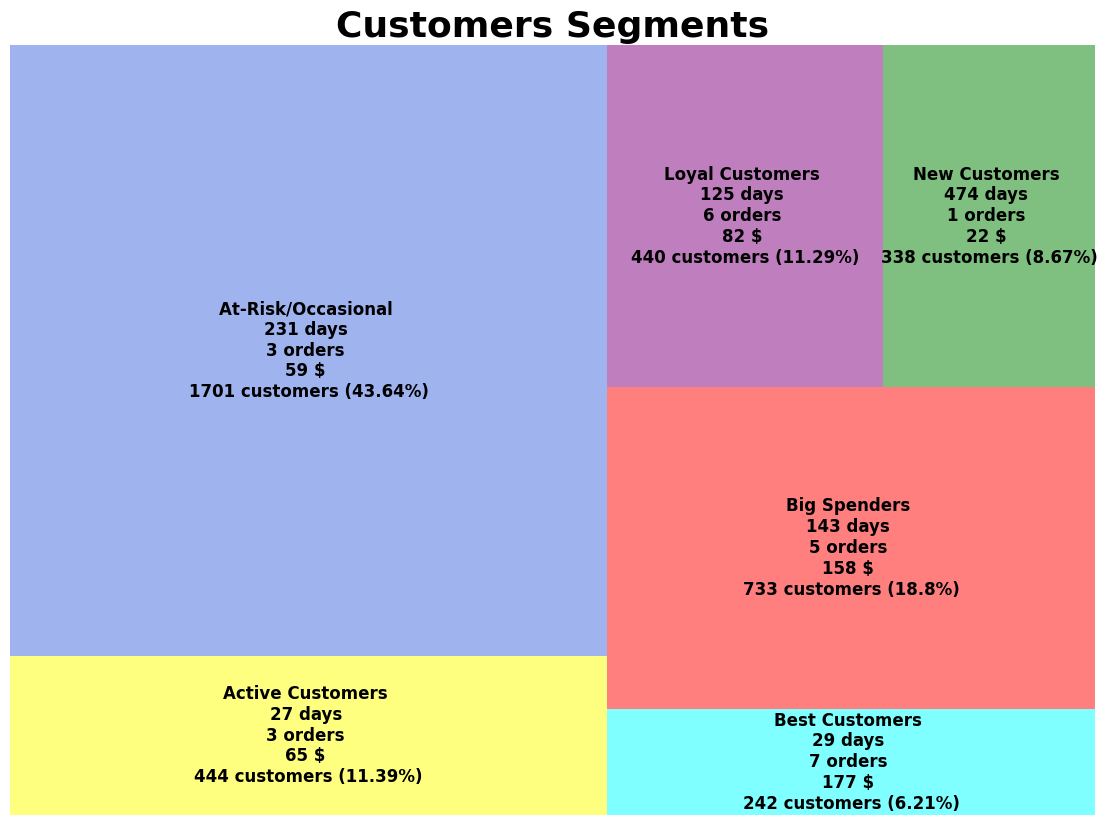

In [52]:
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(14, 10)
colors_dict = {'Active Customers':'yellow','Big Spenders':'royalblue', 'Occasional Customers':'cyan',
               'Lost Customers':'red', 'Loyal Customers':'purple', 'New Customers':'green', 'Best Customers':'gold'}
squarify.plot(sizes=rfm_agg['Count'],
              text_kwargs={'fontsize':12,'weight':'bold', 'fontname':"sans serif"},
              color=colors_dict.values(),
              label=['{} \n{:.0f} days \n{:.0f} orders \n{:.0f} $ \n{:.0f} customers ({}%)'.format(*rfm_agg.iloc[i])
                      for i in range(0, len(rfm_agg))], alpha=0.5 )
plt.title("Customers Segments",fontsize=26,fontweight="bold")
plt.axis('off')
plt.show()

Best Customers – High recency, frequency, and monetary score.
New Customers – Very low recency, frequency, and monetary.
Big Spenders – High monetary, regardless of frequency or recency.
Loyal Customers – High frequency, regardless of recency or monetary.
Active Customers – High recency, regardless of frequency or monetary.
At-Risk/Occasional – Any other scenario, including lower recency and frequency.

In [53]:
output_file = 'rfm_df.csv'
rfm_df.to_csv(output_file, index=True, encoding='utf-8')

In [54]:
import plotly.express as px

fig = px.scatter(rfm_agg, x="RecencyMean", y="MonetaryMean", size="FrequencyMean", color="RFM_Level",
           hover_name="RFM_Level", size_max=100)
fig.show()